<a href="https://colab.research.google.com/github/bhuvnk/skunworks/blob/main/Phase1/2.%20RelationNet/RelationNet_Omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Relation Netwoks: Omniglot dataset


`Credit:` https://github.com/floodsung/LearningToCompare_FSL


##Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Import data

The Omniglot dataset is taken on [the official GitHub repository](https://github.com/brendenlake/omniglot)

In [ ]:
#Download and Extract
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

--2020-11-08 06:56:12--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2020-11-08 06:56:12--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  24.0MB/s    in 0.3s    

2020-11-08 06:56:13 (24.0 MB/s) - ‘images_evaluation.zip’ saved [64

## Reading the Omniglot

1623 Handwritten Character || 50 Alphabets || By 20 People

1623 * 4 = 6492; if we consider orthogonal flips

* 30 Alphabets | Background Set | Training
* 20 Alphabets | Evaluation Set | Testing


In [ ]:
from tqdm.notebook import tqdm
def load_characters(root, alphabet):

    X = []
    y = []
    
    alphabet_path = os.path.join(root, alphabet)
    characters = os.listdir(alphabet_path)
    
    for char in characters:
        char_path = os.path.join(alphabet_path, char)
        images = os.listdir(char_path)
        
        for img in images:
            image = cv2.imread(os.path.join(char_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            X.extend((image, rotated_90, rotated_180, rotated_270))
            y.extend((
                alphabet + '_' + char + '_0',
                alphabet + '_' + char + '_90',
                alphabet + '_' + char + '_180',
                alphabet + '_' + char + '_270'
            ))
            
            # X.append(image)
            # y.append(f'{alphabet}_{char}')
    
    return X, y


def read_images(root):

    X_data = []
    y_data = []
    
    print('Loading Data')
    
    alphabets = os.listdir(root)
    for alphabet in tqdm(alphabets):
        X, y = load_characters(root, alphabet)
        X_data.extend(X)
        y_data.extend(y)
    
    return np.array(X_data), np.array(y_data)

In [ ]:
trainx, trainy = read_images('images_background')

Loading Data


In [ ]:
trainx.shape, trainy.shape

((77120, 28, 28, 3), (77120,))

* Training set | 77,120 images | 964 * 4 = 3,856 characters * 20 people | images_background
* Testing set | 52,720 images | 659 * 4 = 2,636 characters * 20 People | images_evaluation

##Create samples

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
    Returns a Task with support and query set combined
    task sample : (n_way, n_support+n_query, (image dim))
    plus these info: n_way, n_support, n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  return sample.permute(0,1,4,2,3)

As an example, let's pick a sample and display it

*   n_way = 8
*   n_support = 5
*   n_query = 5




In [ ]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
sample_example.shape

torch.Size([8, 10, 3, 28, 28])

In [ ]:
sample_ex = sample_example.contiguous().view(8 * 10, *sample_example.size()[2:])
sample_ex.shape

torch.Size([80, 3, 28, 28])

In [ ]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


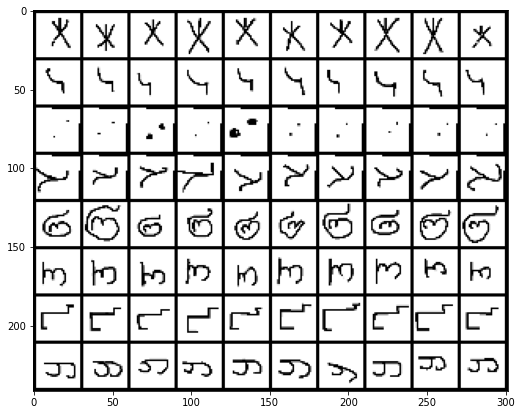

In [ ]:
display_sample(sample_example)

##Build model

In [ ]:
## Encoder
class CNNEncoder(nn.Module):
    """Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,64,kernel_size=3,padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())
        self.layer4 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        #out = out.view(out.size(0),-1)
        return out # 64

In [ ]:
class RelationNetwork(nn.Module):
    '''Decoder: relation part'''
    def __init__(self,input_size,hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(128,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,64,kernel_size=3,padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    import math
    if classname.find('Conv') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        n = m.weight.size(1)
        m.weight.data.normal_(0, 0.01)
        m.bias.data = torch.ones(m.bias.data.size())

##Train

In [ ]:
from tqdm import tqdm_notebook
from tqdm import tnrange

def train(feature_encoder,relation_network,
          feature_encoder_optim, relation_network_optim,
          train_x, train_y,
          n_way, n_support, n_query,
          episodes=1000, epochs=1):

    # Step 1: neural networks
    print("init neural networks")

    feature_encoder.cuda()
    relation_network.cuda()

    feature_encoder_scheduler = optim.lr_scheduler.StepLR(feature_encoder_optim,step_size=100000,gamma=0.5)
    relation_network_scheduler = optim.lr_scheduler.StepLR(relation_network_optim,step_size=100000,gamma=0.5)

    # Step 2: Start Training
    print("Training...")

    # last_accuracy = 0.0

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        running_acc = 0.0

        pbar = tqdm(total=episodes, desc='Epoch {}'.format(epoch))

        for episode in range(episodes):

            # batch_dataloader is to batch samples for training
            sample_images = extract_sample(n_way, n_support, n_query, train_x, train_y)
            sample_images = sample_images.cuda()

            x_support = sample_images[:, :n_support].contiguous().view(n_way * n_support, *sample_images.size()[2:])
            x_query = sample_images[:, n_support:].contiguous().view(n_way * n_query, *sample_images.size()[2:])

            #target indices are 0 ... n_way-1
            # target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
            # target_inds = Variable(target_inds, requires_grad=False)
            # target_inds = target_inds.cuda()

            target_inds = torch.arange(0, n_way).view(n_way, 1).expand(n_way, n_query).reshape(n_way*n_query,1).long()
            one_hot_labels = Variable(torch.zeros(n_query*n_way, n_way).scatter_(1, target_inds.view(-1,1), 1), requires_grad=False)
            one_hot_labels = one_hot_labels.cuda()

            # calculate features
            support_features = feature_encoder(x_support) # 5x64*5*5
            support_features = support_features.view(n_way,n_support,feature_dim,5,5)
            support_features = torch.sum(support_features,1).squeeze(1)
            query_features = feature_encoder(x_query) # 20x64*5*5

            # calculate relations
            # each query sample link to every support samples to calculate relations
            # to form a n_way*n_supportx128 matrix for relation network
            support_features_ext = support_features.unsqueeze(0).repeat(n_query*n_way,1,1,1,1)
            query_features_ext = query_features.unsqueeze(0).repeat(n_way,1,1,1,1)
            query_features_ext = torch.transpose(query_features_ext,0,1)

            relation_pairs = torch.cat((support_features_ext,query_features_ext),2).view(-1,feature_dim*2,5,5)
            relations = relation_network(relation_pairs).view(-1,n_way)

            mse = nn.MSELoss().cuda()
            loss = mse(relations,one_hot_labels)

            _,predict_labels = torch.max(relations.data,1)
            _,target_labels = torch.max(one_hot_labels.data,1) # just some lazy code
                      
            
            rewards = [1 if predict_labels[j]==target_labels[j] else 0 for j in range(n_way*n_support)]
            acc = (np.sum(rewards)/(n_way*n_support))

            running_acc += acc
            running_loss += loss

            feature_encoder.zero_grad()
            relation_network.zero_grad()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(feature_encoder.parameters(),0.5)
            torch.nn.utils.clip_grad_norm_(relation_network.parameters(),0.5)

            feature_encoder_optim.step()
            relation_network_optim.step()

            feature_encoder_scheduler.step()
            relation_network_scheduler.step()

            # Progress Bar Logging
            pbar.update(1)
            pbar.set_postfix({'Loss': loss.item(), 
                              'Acc': acc.item()})
        
        pbar.close()
        epoch_loss = running_loss / episodes
        epoch_acc = running_acc / episodes
        # print(f'epoch:{epoch+1}; loss: {epoch_loss.value()}; Accuracy: {epoch_acc.value()}')  
        print(f'epoch:{epoch}; loss: {epoch_loss.item()}; Accuracy: {epoch_acc.item()}')  

# Start Trainning

In [ ]:
episodes = 10000
epochs = 5
n_way, n_support, n_query = 5, 1, 5

In [ ]:
# train_x, train_y = read_images('images_background')

In [ ]:
lr= 0.001

## Relationnet stuff
feature_dim = 64
relation_dim = 8

feature_encoder = CNNEncoder()
relation_network = RelationNetwork(feature_dim,relation_dim)

# feature_encoder.apply(weights_init)
# relation_network.apply(weights_init)

feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=lr)
relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=lr)



In [ ]:
train(feature_encoder,relation_network,
          feature_encoder_optim, relation_network_optim,
          trainx, trainy,
          n_way, n_support, n_query,
          episodes=episodes, epochs=epochs)

init neural networks
Training...



epoch:1; loss: 0.02089385688304901; Accuracy: 0.9698800000000032



epoch:2; loss: 0.009511022828519344; Accuracy: 0.991680000000001



epoch:3; loss: 0.0074314274825155735; Accuracy: 0.9933000000000002



epoch:4; loss: 0.0061285123229026794; Accuracy: 0.99516



epoch:5; loss: 0.005565961357206106; Accuracy: 0.995380000000001


In [ ]:
torch.save({'feature_encoder': feature_encoder.state_dict(),
            'relation_network': relation_network.state_dict()}, "Model_para.pth")

##Test

In [ ]:
from tqdm import tqdm_notebook
from tqdm import tnrange

def test(feature_encoder,relation_network,
          feature_encoder_optim, relation_network_optim,
          train_x, train_y,
          n_way, n_support, n_query,
          episodes=1000, epochs=1):

    # Step 1: neural networks
    print("init neural networks")

    feature_encoder.cuda()
    relation_network.cuda()
    
    # Step 2: Start Testing
    print("Testing...")

    # last_accuracy = 0.0

    for epoch in range(1, epochs+1):
        running_loss = 0.0
        running_acc = 0.0

        pbar = tqdm(total=episodes, desc='Epoch {}'.format(epoch))
        with torch.no_grad():

            for episode in range(episodes):

                # batch_dataloader is to batch samples for training
                sample_images = extract_sample(n_way, n_support, n_query, train_x, train_y)
                sample_images = sample_images.cuda()

                x_support = sample_images[:, :n_support].contiguous().view(n_way * n_support, *sample_images.size()[2:])
                x_query = sample_images[:, n_support:].contiguous().view(n_way * n_query, *sample_images.size()[2:])

                target_inds = torch.arange(0, n_way).view(n_way, 1).expand(n_way, n_query).reshape(n_way*n_query,1).long()
                one_hot_labels = Variable(torch.zeros(n_query*n_way, n_way).scatter_(1, target_inds.view(-1,1), 1), requires_grad=False)
                one_hot_labels = one_hot_labels.cuda()

                # calculate features
                support_features = feature_encoder(x_support) # 5x64*5*5
                support_features = support_features.view(n_way,n_support,feature_dim,5,5)
                support_features = torch.sum(support_features,1).squeeze(1)
                query_features = feature_encoder(x_query) # 20x64*5*5

                # calculate relations

                support_features_ext = support_features.unsqueeze(0).repeat(n_query*n_way,1,1,1,1)
                query_features_ext = query_features.unsqueeze(0).repeat(n_way,1,1,1,1)
                query_features_ext = torch.transpose(query_features_ext,0,1)

                relation_pairs = torch.cat((support_features_ext,query_features_ext),2).view(-1,feature_dim*2,5,5)
                relations = relation_network(relation_pairs).view(-1,n_way)

                mse = nn.MSELoss().cuda()
                loss = mse(relations,one_hot_labels)

                _,predict_labels = torch.max(relations.data,1)
                _,target_labels = torch.max(one_hot_labels.data,1) # lazy coding
                          
                
                rewards = [1 if predict_labels[j]==target_labels[j] else 0 for j in range(n_way*n_support)]
                acc = (np.sum(rewards)/(n_way*n_support))

                running_acc += acc
                running_loss += loss

                # Progress Bar Logging
                pbar.update(1)
                pbar.set_postfix({'Loss': loss.item(), 
                                  'Acc': acc.item()})
            
            pbar.close()
            epoch_loss = running_loss / episodes
            epoch_acc = running_acc / episodes
            # print(f'epoch:{epoch+1}; loss: {epoch_loss.value()}; Accuracy: {epoch_acc.value()}')  
            print(f'epoch:{epoch}; loss: {epoch_loss.item()}; Accuracy: {epoch_acc.item()}')  

In [ ]:
n_way = 5
n_support = 1
n_query = 5

test_episode = 1000

In [ ]:
testx, testy = read_images('images_evaluation')

Loading Data


In [ ]:
# # Load Checkpoint
checkpoint = torch.load('/content/Model_para.pth')
feature_encoder = CNNEncoder()
relation_network = RelationNetwork(feature_dim,relation_dim)
feature_encoder.load_state_dict(checkpoint['feature_encoder'])
relation_network.load_state_dict(checkpoint['relation_network'])


feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(),lr=lr)
relation_network_optim = torch.optim.Adam(relation_network.parameters(),lr=lr)

feature_encoder_scheduler = optim.lr_scheduler.StepLR(feature_encoder_optim,step_size=100000,gamma=0.5)
relation_network_scheduler = optim.lr_scheduler.StepLR(relation_network_optim,step_size=100000,gamma=0.5)


In [ ]:
test(feature_encoder,relation_network,
     feature_encoder_optim, relation_network_optim,
     testx, testy,
     n_way, n_support, n_query,
     episodes=test_episode)

init neural networks
Testing...



epoch:1; loss: 0.010159987956285477; Accuracy: 0.9877999999999993
